In [1]:
import os
import numpy as np
import pandas as pd
import rosbag
import velodyne_decoder as vd
import itertools

import io
import matplotlib.pyplot as plt
from PIL import Image

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [8]:
BAG_PATH = 'data/ICar/sensors_2023-03-20-10-00-08.bag'

In [9]:
bag = rosbag.Bag(BAG_PATH)
messages = bag.read_messages()

In [20]:
bag.get_type_and_topic_info().topics.keys()

dict_keys(['/diagnostics', '/image/show/throttled', '/image_points_last', '/imu/data', '/imu/time_diff', '/imu/time_ref', '/velodyne_packets', '/velodyne_position_packets'])

In [10]:
messages = bag.read_messages(topics=['/image/show/throttled'])

In [11]:
topic, msg, t = next(messages)

In [109]:
type(msg.data)

bytes

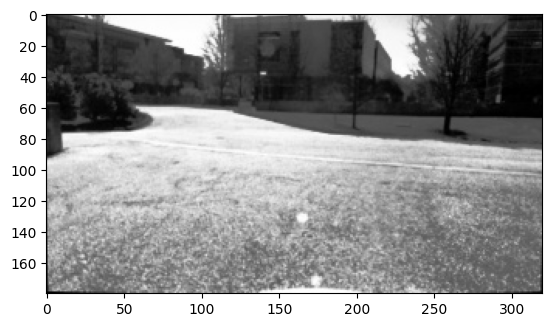

In [15]:
img = Image.open(io.BytesIO(msg.data))

import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()


In [ ]:
for topic, msg, t in bag.read_messages():
    print(f"{topic}: {msg}")
bag.close()

In [16]:
config = vd.Config(model='VLP-16')
lidar_topics = ['/velodyne_packets']
cloud_arrays = []
for stamp, points, topic in itertools.islice(vd.read_bag(BAG_PATH, topics=lidar_topics, config=config), 5000, 5001):
    cloud_arrays.append(points)

In [17]:
pointcloud = np.concatenate(cloud_arrays)

ResultTuple(stamp=genpy.Time[1679321311568900108], points=array([[ 9.7294009e-01, -7.1789719e-02, -2.6140723e-01,  2.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 8.5614185e+00, -6.3171601e-01,  1.4984636e-01,  9.0000000e+00,
         8.0000000e+00,  2.3040000e-06],
       [ 7.7989922e+00, -5.7682788e-01, -1.8054571e+00,  8.0000000e+00,
         1.0000000e+00,  4.6079999e-06],
       ...,
       [ 3.5894173e+01, -1.5797271e+00,  8.2948446e+00,  5.3000000e+01,
         1.4000000e+01,  1.0017156e-01],
       [ 1.6879087e+01, -7.4286020e-01, -2.9491076e-01,  3.0000000e+00,
         7.0000000e+00,  1.0017386e-01],
       [ 7.8029232e+00, -3.4341198e-01,  2.0928109e+00,  8.0000000e+00,
         1.5000000e+01,  1.0017617e-01]], dtype=float32), topic='/velodyne_packets')

In [18]:
messages_img = bag.read_messages(topics=['/image/show/throttled'])

config = vd.Config(model='VLP-16')
lidar_topics = ['/velodyne_packets']
messages_vd = vd.read_bag(BAG_PATH, topics=lidar_topics, config=config)

In [19]:
idx = 5000

topic, msg, t = next(messages_img)

for stamp, points, topic in messages_vd:
    if t.secs < stamp.to_sec() < t.secs + 0.25:
        pointcloud = points
    elif t.secs + 0.25 < stamp.to_sec():
        break

In [248]:
t.secs

1679320817

In [250]:
stamp.to_sec()

1679320817.258984

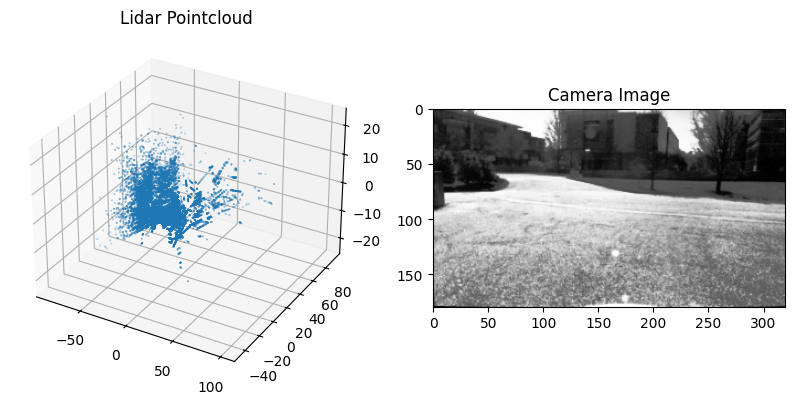

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import io

# display lidar pointcloud
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], s=0.1)
# ax1.set_aspect([1,1,1]) # set the scale of x, y, and z axis to be the same
ax1.set_title('Lidar Pointcloud')

# display image
img = Image.open(io.BytesIO(msg.data))
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(img)
ax2.set_title('Camera Image')
# ax2.set_title(f"Timestamp: {t.to_sec()}", loc='right')

plt.show()


In [24]:
for i in range(50):
    next(messages_img)

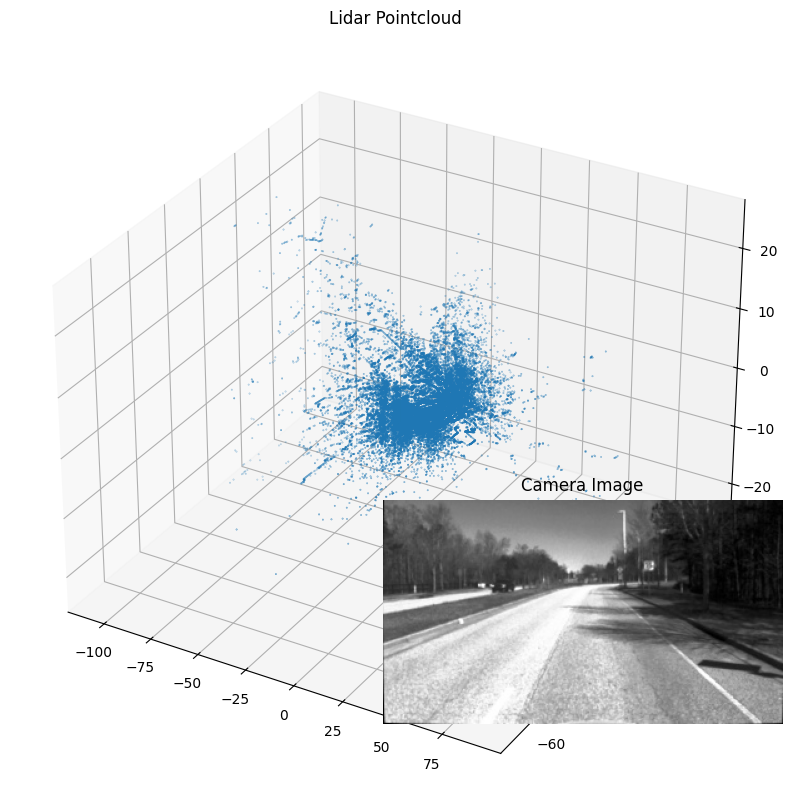

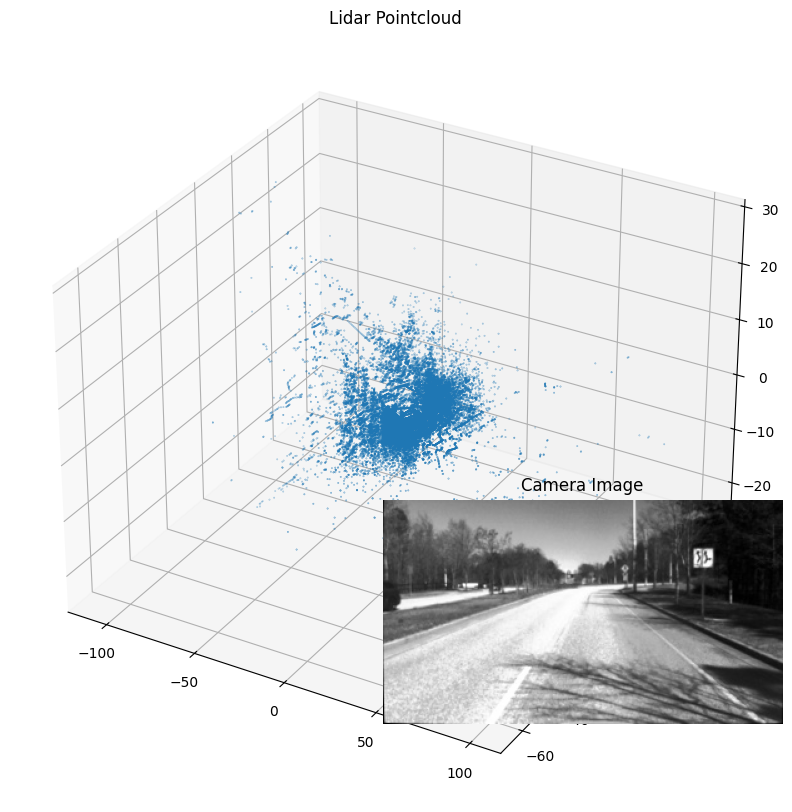

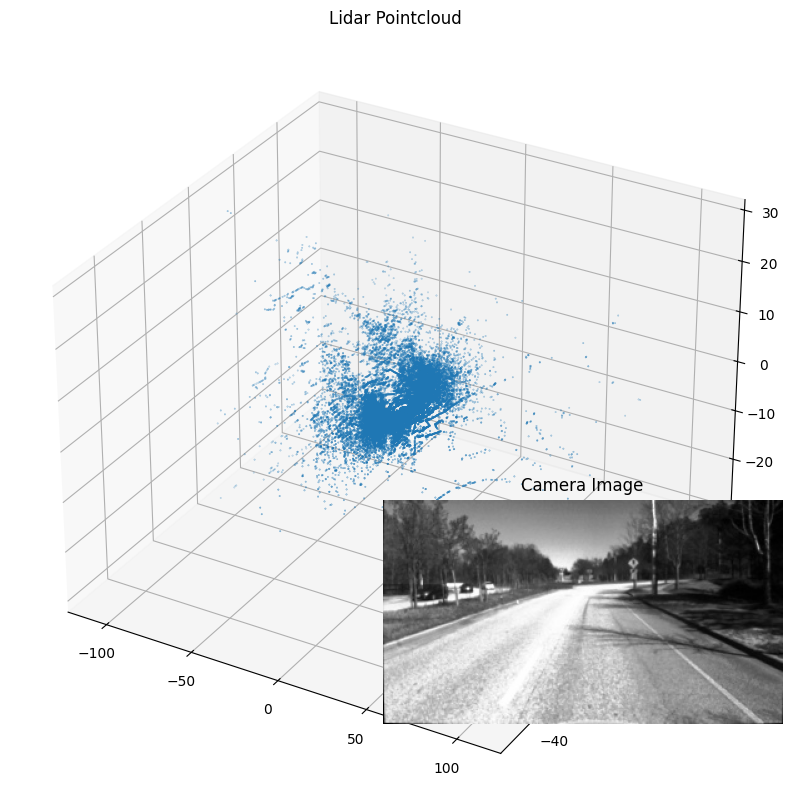

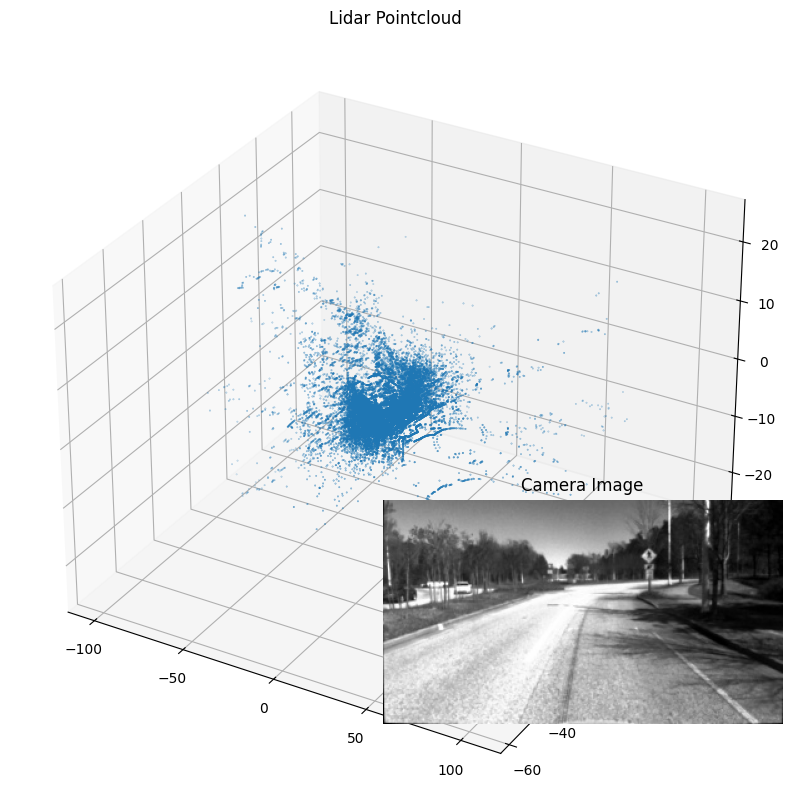

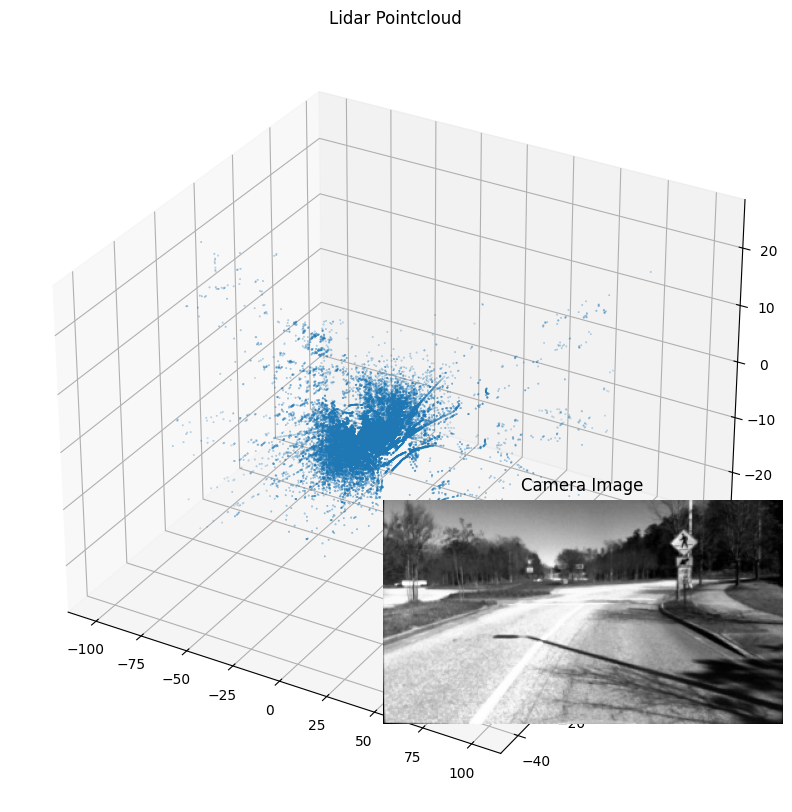

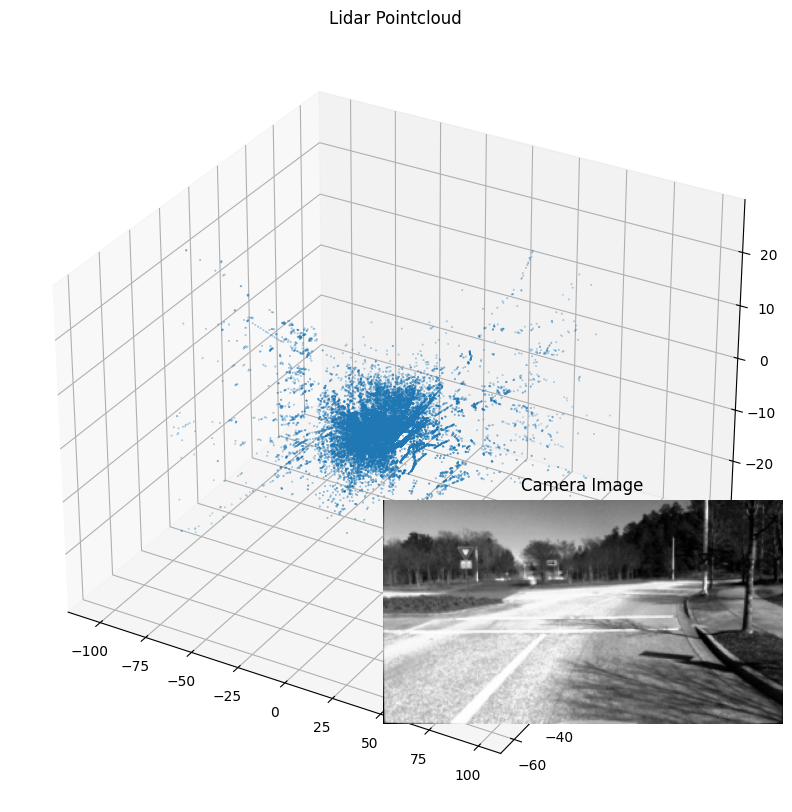

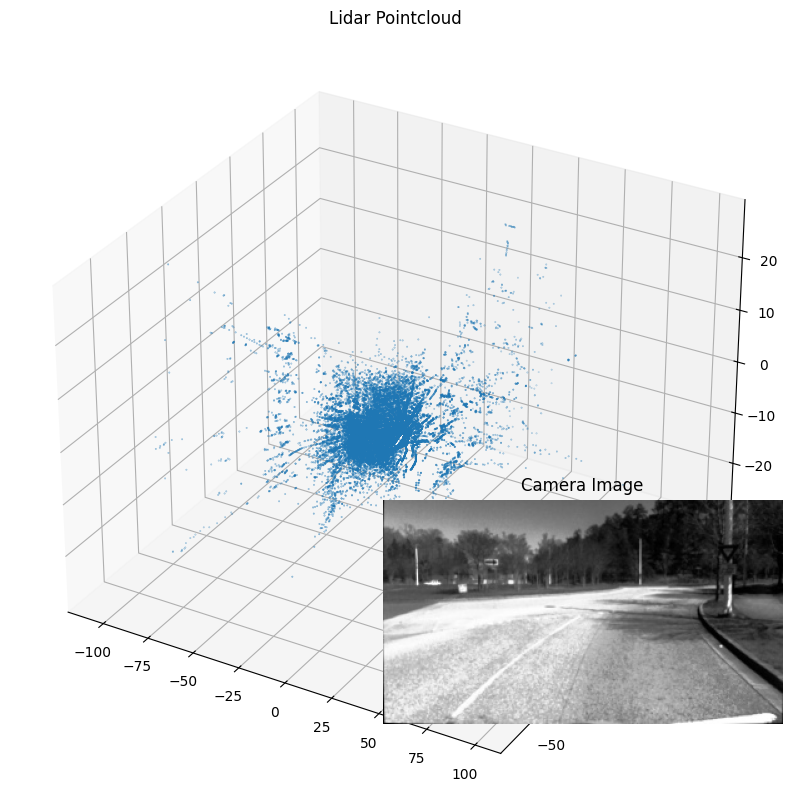

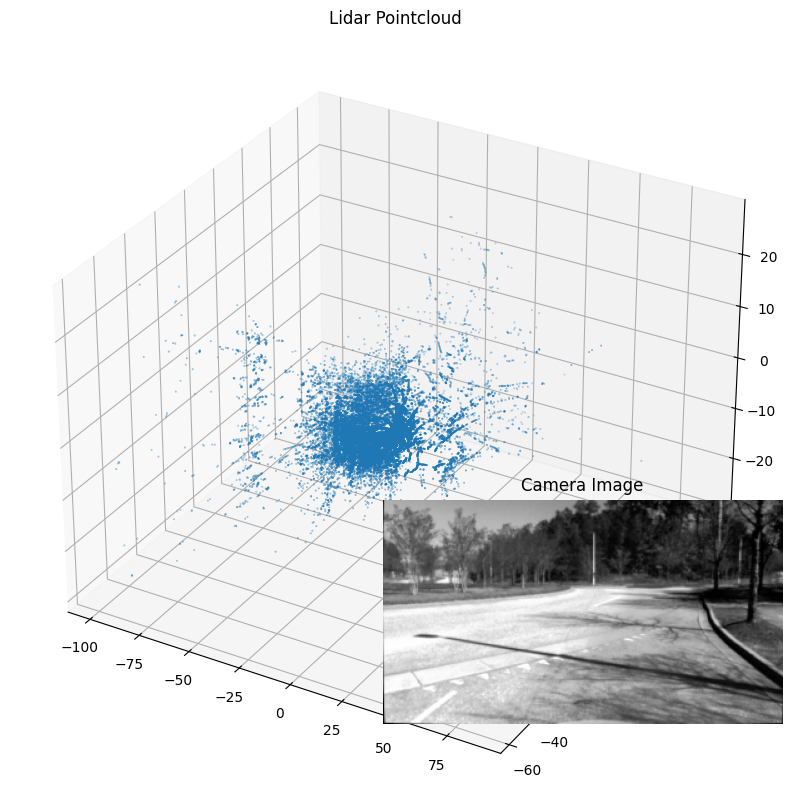

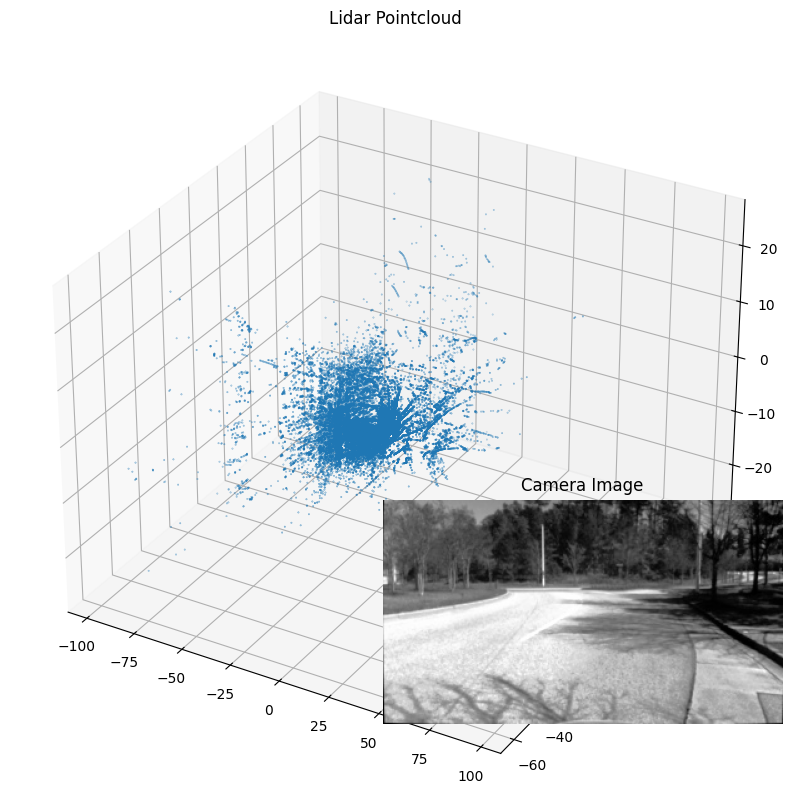

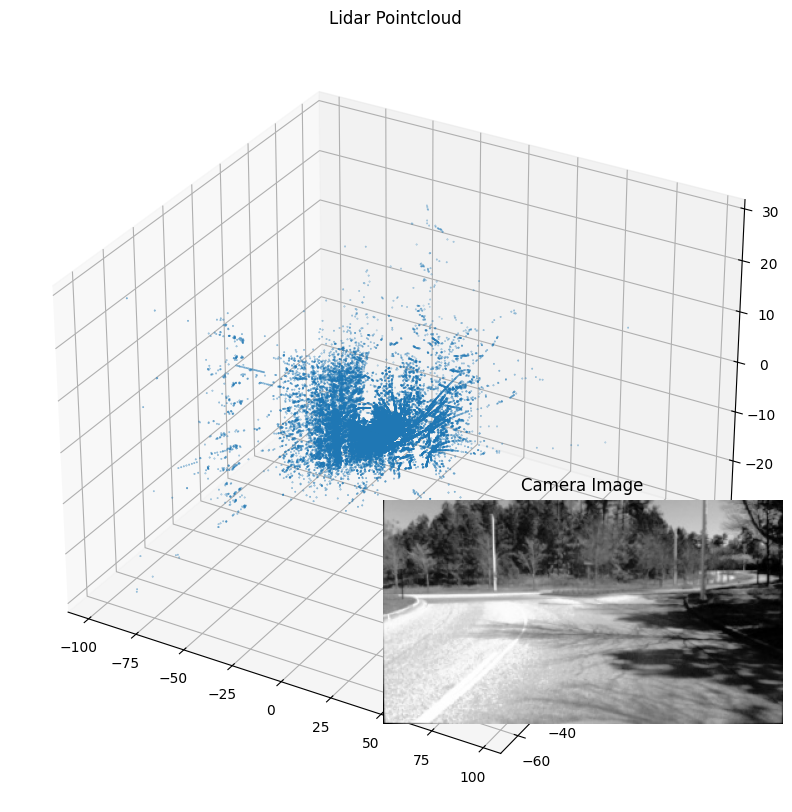

In [26]:
import cv2
import os

img_width, img_height = 1000, 1000

# create a video writer object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
video_out = cv2.VideoWriter('output.avi', fourcc, 1, (img_width, img_height))

# read messages for 10 seconds
start_time = t.to_sec()

# create directory if it doesn't exist
if not os.path.exists('imgs'):
    os.makedirs('imgs')

idx = 0

while t.to_sec() - start_time < 10:
    # read image message
    topic, msg, t = next(messages_img)
    img = Image.open(io.BytesIO(msg.data))
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # read lidar message
    for stamp, points, topic in messages_vd:
        if t.secs < stamp.to_sec() < t.secs + 0.25:
            pointcloud = points
        elif t.secs + 0.25 < stamp.to_sec():
            break

    # plot lidar pointcloud on image
    # display lidar pointcloud
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    ax1.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], s=0.1)
    ax1.set_title('Lidar Pointcloud')

    # display image
    img = Image.open(io.BytesIO(msg.data))
    ax2 = fig.add_axes([0.5, 0.1, 0.4, 0.4])
    ax2.imshow(img)
    ax2.axis('off')
    ax2.set_title('Camera Image')

    # convert plot to image
    fig.canvas.draw()
    plot_img = np.array(fig.canvas.renderer.buffer_rgba())
    plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGBA2BGR)

    # save plot image to file
    filename = f'imgs/{idx}.png'
    cv2.imwrite(filename, plot_img)
    idx += 1

    # write image to video
    video_out.write(plot_img)

# release video writer object
video_out.release()


In [32]:
img1 = np.array(Image.open('./output.png'))
img2 = np.array(Image.open('./output2.png'))

print(img1.shape)
print(img2.shape)

(812, 792, 4)
(427, 735, 4)
